# ABLATION STUDY
#### In the following notebook we show the results of the ablation study performed by disabling some component of the model *PSA-GAN*. The performances are measured by using the *NRMSE* and the *Context-FID*, togheter with a plot in order to visualize graphically the behaviour of the model on the test set. 

# IMPORTS

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import plotting
import lstm
import metrics
import train
import torch.nn as nn
import progressive_blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam


c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and plot train

Any missing value: V2    False
dtype: bool
all training set length:  48000


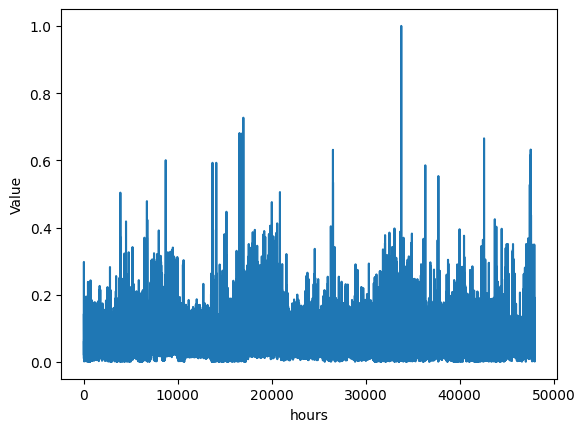

In [2]:
path="Models/M4/"

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Monthly-train.csv')

training_set = training_set.iloc[:,1:2] #electricity values in time
any_missing_train = training_set.isnull().any()
print("Any missing value:",any_missing_train)
print("all training set length: ",len(training_set))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)

plotting.plot_dataset(training_set, x_axis="hours", y_axis="Value")

## Load and plot test

Any missing value: V2    False
dtype: bool
all testing set length:  48000


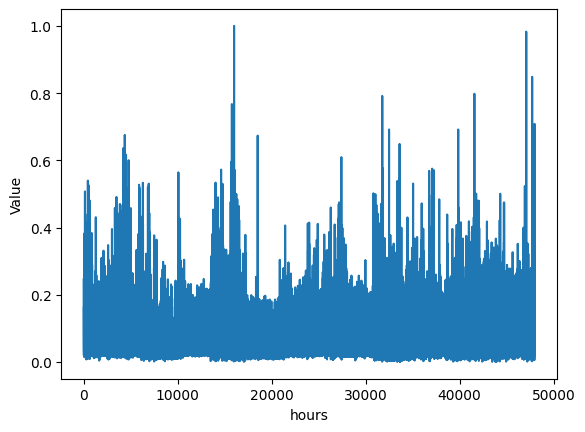

In [3]:
testing_set = pd.read_csv('./Datasets/M4-Dataset/Test/Monthly-test.csv')

testing_set = testing_set.iloc[:,1:2] #electricity values in time
any_missing_test = testing_set.isnull().any()
print("Any missing value:",any_missing_train)
print("all testing set length: ",len(testing_set))

sc = MinMaxScaler()
testing_set = sc.fit_transform(testing_set)

plotting.plot_dataset(testing_set, x_axis="hours", y_axis="Value")

## Create sequences for train

In [4]:
seq_length = 512 #it is tau in the paper

train_set=training_set[:42500]
print("train_set.shape:",train_set.shape)

x_train, y_train = utils.sliding_windows(train_set, seq_length)
trainX=torch.Tensor(np.array(x_train))
print("trainX.shape:",trainX.shape)
size=trainX.size(0)

sequences_train=utils.real_seq(training_set,seq_length)
sequences_train=sequences_train[:size]

sequences_train=torch.Tensor(sequences_train)
sequences_train.unsqueeze(0).unsqueeze(1)
sequences_train=sequences_train.permute(0,2,1)
print("Sequences_train.shape",sequences_train.shape)

train_set.shape: (42500, 1)
trainX.shape: torch.Size([41987, 512, 1])
Sequences_train.shape torch.Size([41987, 1, 512])


## Create sequences for test

In [5]:
test_set=testing_set[:42500]
print(test_set.shape)

x_test, y_test= utils.sliding_windows(test_set, seq_length)
testX=torch.Tensor(np.array(x_test))
print("testX.shape:",testX.shape)
size=testX.size(0)

sequences_test=utils.real_seq(testing_set,seq_length)
sequences_test=sequences_test[:size]

sequences_test=torch.Tensor(sequences_test)
sequences_test.unsqueeze(0).unsqueeze(1)
sequences_test=sequences_test.permute(0,2,1)
print("Sequences_test.shape",sequences_test.shape)

(42500, 1)
testX.shape: torch.Size([41987, 512, 1])
Sequences_test.shape torch.Size([41987, 1, 512])


### Test loader for evaluations

In [6]:
test= TensorDataset(testX, sequences_test)
test_loader = DataLoader(test, batch_size=121, shuffle=False)
embedder=torch.load("Models/Embedder/embedder_model.pt")

In [7]:
utils.create_folder(path)

Directory already exists: Models/M4/


## PSA-GAN

Cuda enabled: using GPU
Directory already exists: Models/M4/PSA-GAN/

Starting training: PSA-GAN
Total Epochs: 15 
Blocks to add with fade: 2
Timestamp to add blocks: 5
Fade-in True
ML True
SA True

[Epoch 1/15] [Batch 1/347] [D loss: 1.335573] [G loss: 1.698464] [Fade-in: 1.000000] [FID: 0.000051]
Improvement-Detected, model saved
[Epoch 1/15] [Batch 2/347] [D loss: 1.335058] [G loss: 1.630444] [Fade-in: 1.000000] [FID: 0.000038]
Improvement-Detected, model saved
[Epoch 1/15] [Batch 3/347] [D loss: 1.334899] [G loss: 1.609706] [Fade-in: 1.000000] [FID: 0.000032]
Improvement-Detected, model saved
[Epoch 1/15] [Batch 4/347] [D loss: 1.334751] [G loss: 1.592458] [Fade-in: 1.000000] [FID: 0.000028]
Improvement-Detected, model saved
[Epoch 1/15] [Batch 5/347] [D loss: 1.334605] [G loss: 1.569209] [Fade-in: 1.000000] [FID: 0.000024]
Improvement-Detected, model saved
[Epoch 1/15] [Batch 6/347] [D loss: 1.334458] [G loss: 1.563978] [Fade-in: 1.000000] [FID: 0.000023]
Improvement-Detected, mod

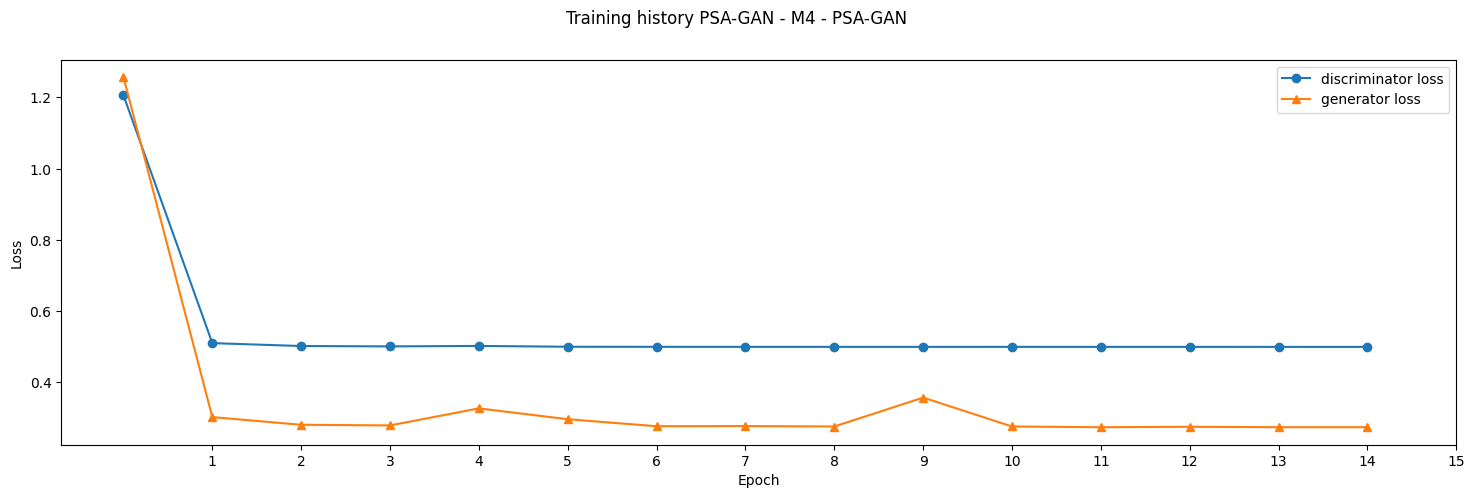

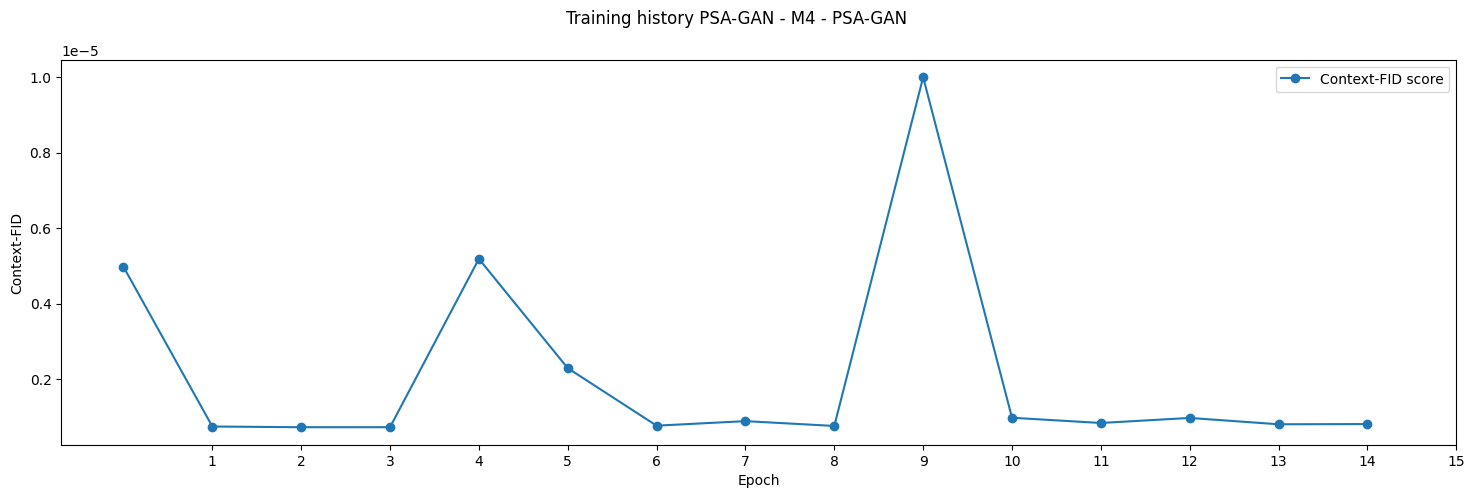

In [8]:
%%time

name_model="PSA-GAN"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=121,
    discriminator_lr=0.00005,
    generator_lr=0.00005,
    num_epochs=15,
    blocks_to_add=2,
    timestamp=5,
    ml=True,
    fade_in=True,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

Model Loaded succesfully:  PSA-GAN


100%|██████████| 347/347 [00:05<00:00, 67.14it/s]


PSA-GAN  NRMSE: 0.001955155748873949


100%|██████████| 347/347 [01:08<00:00,  5.09it/s]

PSA-GAN  FID = 1.2900497775982897e-08 +- 1.2900497775982897e-08
NRMSE on test set:  tensor(0.2333)


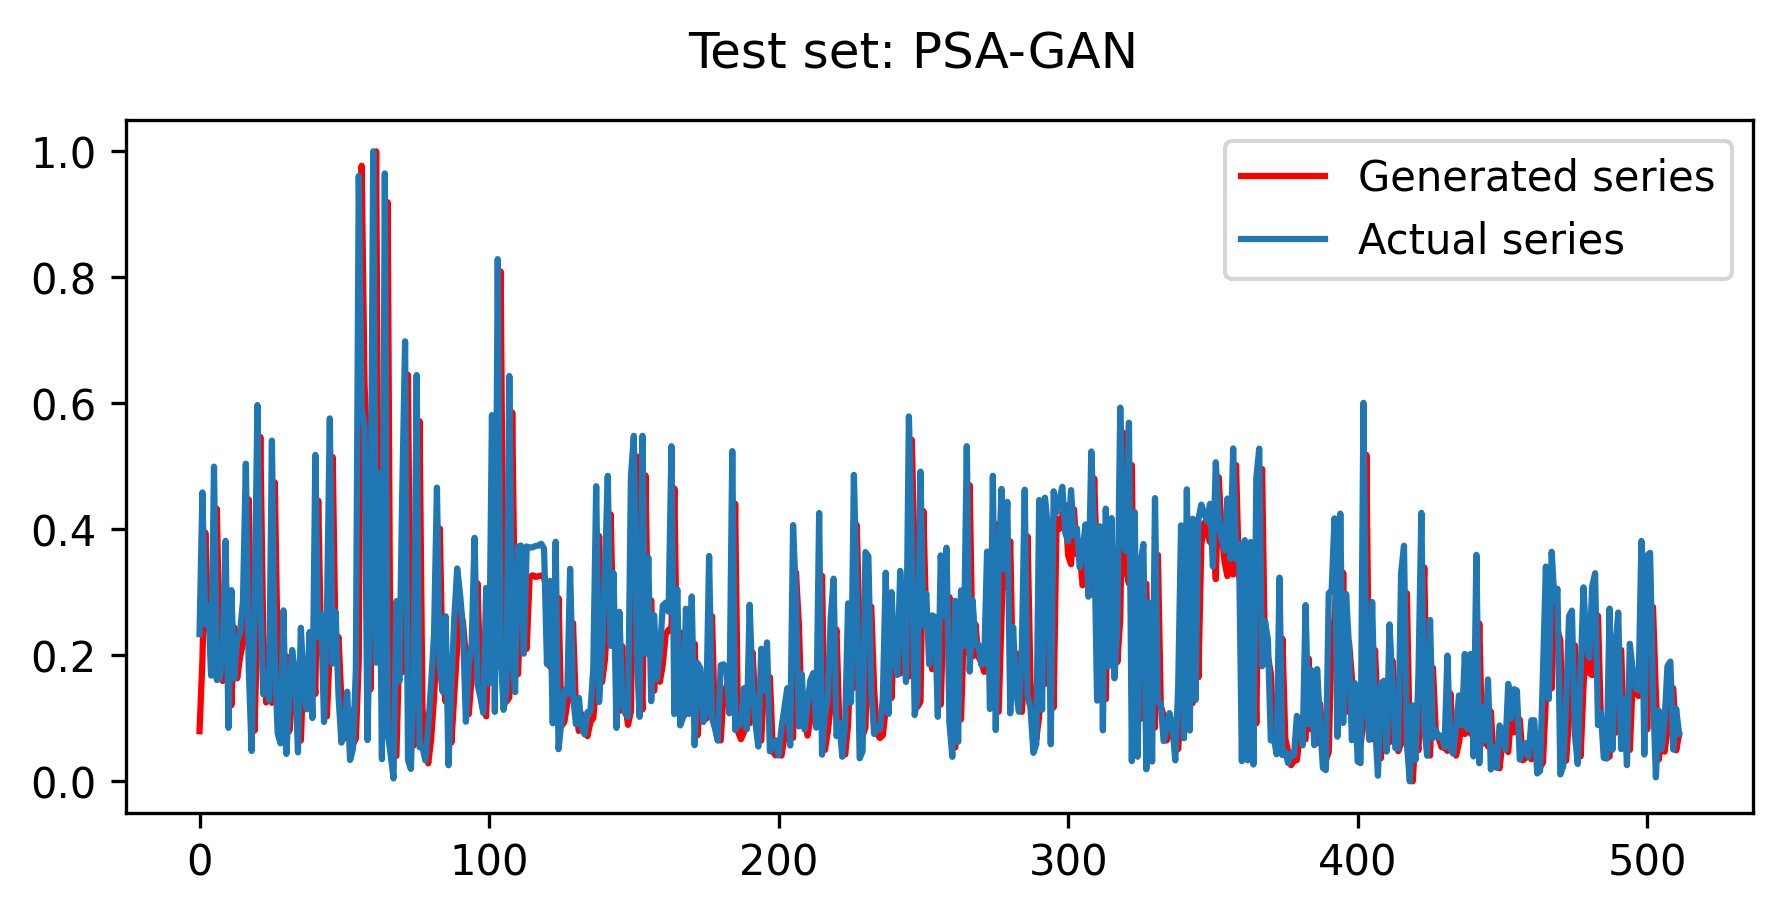

In [10]:
G,D = utils.load_model(path,'PSA-GAN')
name_model='PSA-GAN'

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print(name_model," FID =",mean,"+-",upper)

plotting.prediction_test(seq_length, 121, test_set, testX, G, name_model)

In [ ]:
utils.free_gpu(G)

## w/o Fade-in

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_fade/

Starting training: wo_fade
Total Epochs: 15 
Blocks to add with fade: 2
Timestamp to add blocks: 5
Fade-in False
ML True
SA True

[Epoch 1/15] [Batch 1/347] [D loss: 1.546787] [G loss: 1.691590] [Fade-in: 1.000000] [FID: 0.000025]
[Epoch 1/15] [Batch 2/347] [D loss: 1.523847] [G loss: 1.580878] [Fade-in: 1.000000] [FID: 0.000010]
[Epoch 1/15] [Batch 3/347] [D loss: 1.521033] [G loss: 1.589569] [Fade-in: 1.000000] [FID: 0.000009]
[Epoch 1/15] [Batch 4/347] [D loss: 1.518979] [G loss: 1.596071] [Fade-in: 1.000000] [FID: 0.000008]
[Epoch 1/15] [Batch 5/347] [D loss: 1.516978] [G loss: 1.587304] [Fade-in: 1.000000] [FID: 0.000008]
[Epoch 1/15] [Batch 6/347] [D loss: 1.515004] [G loss: 1.588997] [Fade-in: 1.000000] [FID: 0.000008]
[Epoch 1/15] [Batch 7/347] [D loss: 1.513040] [G loss: 1.585660] [Fade-in: 1.000000] [FID: 0.000008]
[Epoch 1/15] [Batch 8/347] [D loss: 1.511093] [G loss: 1.573333] [Fade-in: 1.000000] [FID: 0.

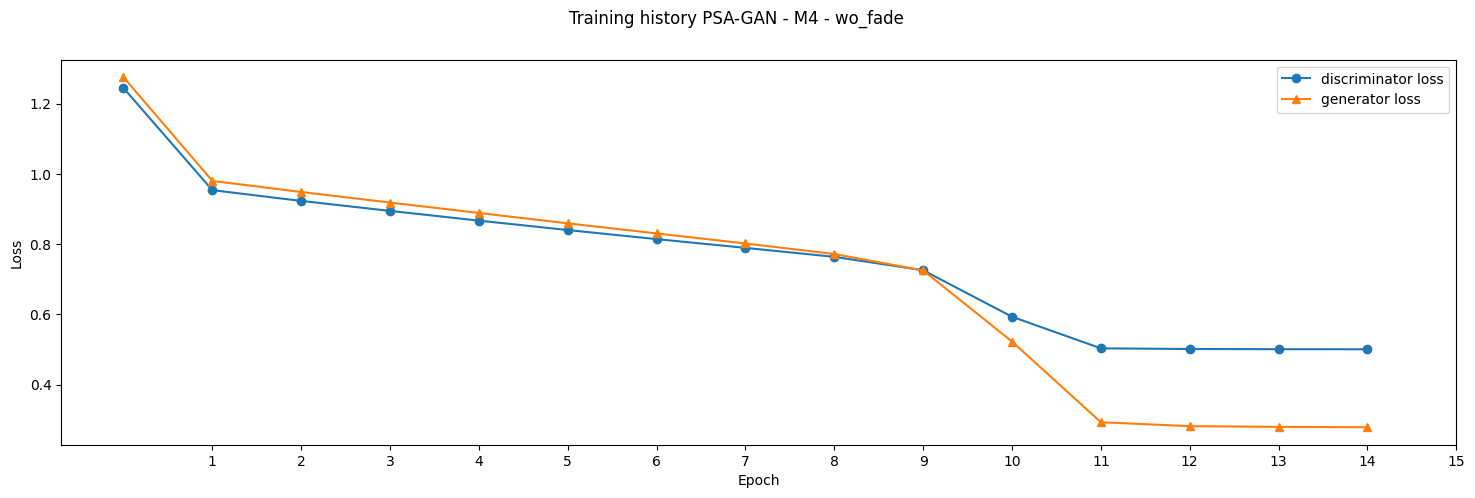

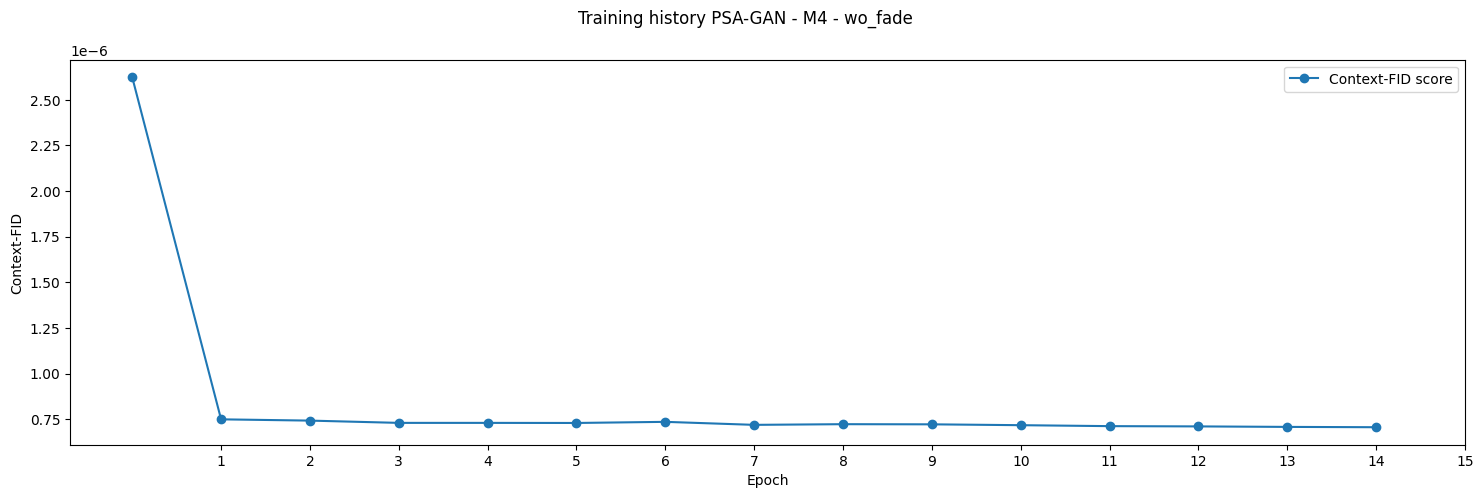

In [11]:
%%time

name_model="wo_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=121,
    discriminator_lr=0.00005,
    generator_lr=0.00005,
    num_epochs=15,
    blocks_to_add=2,
    timestamp=5,
    ml=True,
    fade_in=False,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 347/347 [00:04<00:00, 81.75it/s]


wo_fade  NRMSE: 0.08812727779150009


100%|██████████| 347/347 [01:03<00:00,  5.47it/s]


FID = 7.226717272170745e-05 +- 7.226717272170745e-05
NRMSE on test set:  tensor(3.9089)


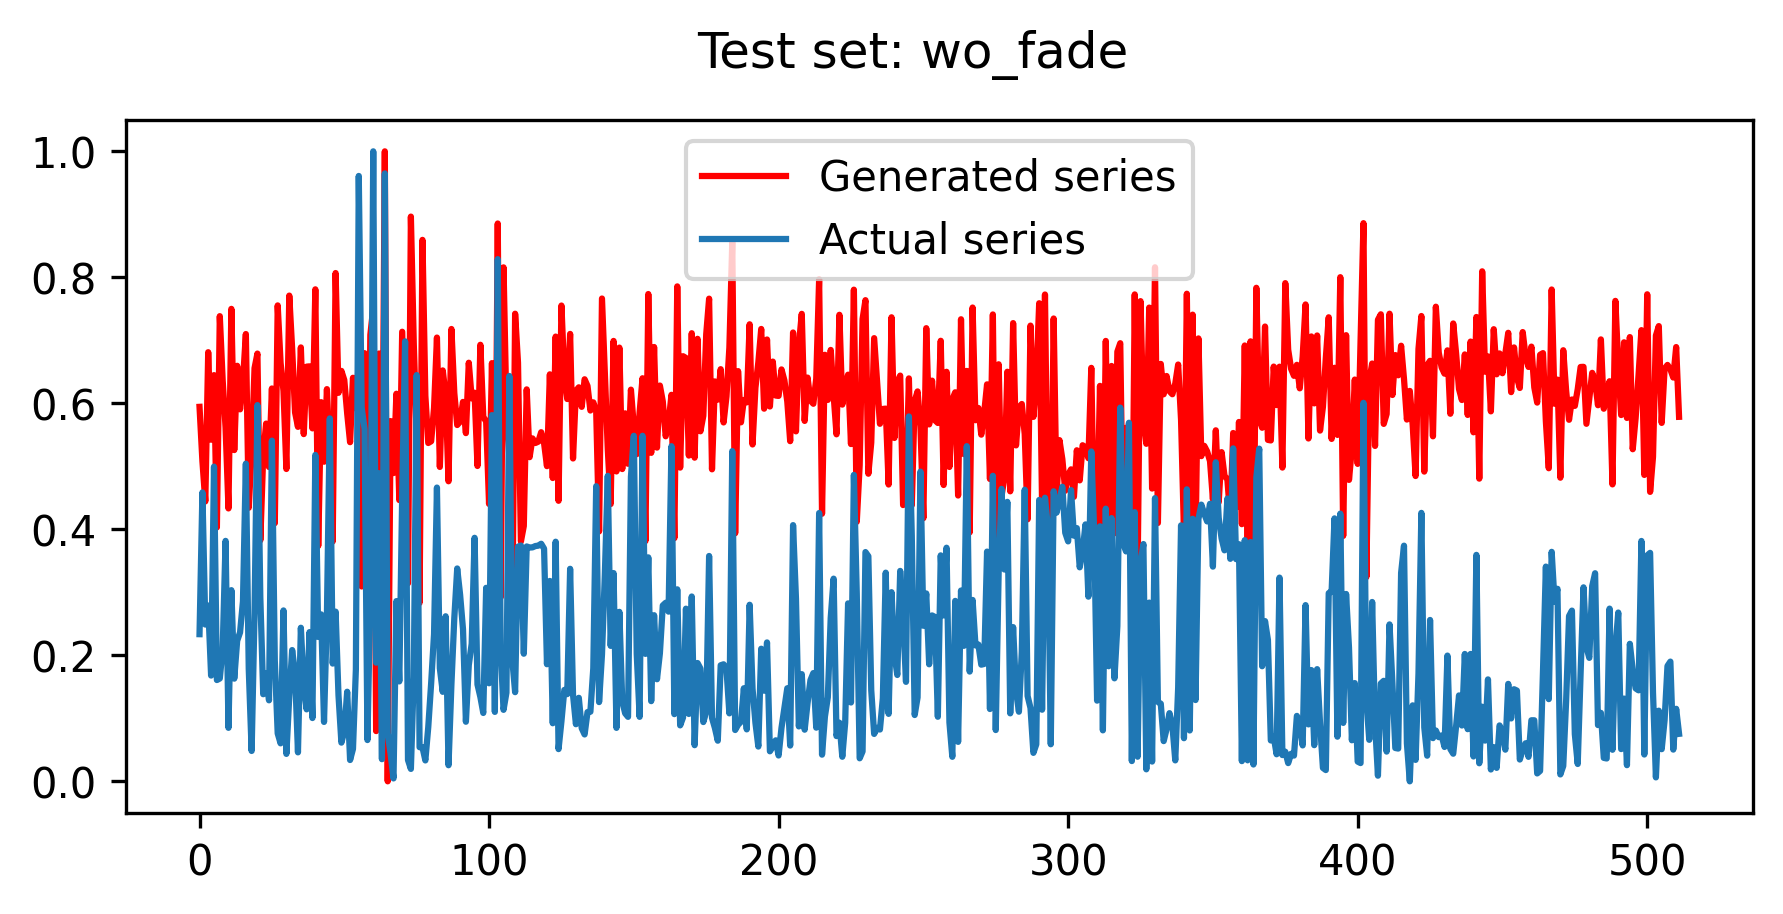

In [12]:
#name_model='wo_fade'
#G,D = utils.load_model(path,name_model)


nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper)

plotting.prediction_test(seq_length, 121, test_set, testX, G, name_model)


In [13]:
utils.free_gpu(G)

## w/o  ML

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_ml/

Starting training: wo_ml
Total Epochs: 15 
Blocks to add with fade: 2
Timestamp to add blocks: 5
Fade-in True
ML False
SA True

[Epoch 1/15] [Batch 1/347] [D loss: 0.999758] [G loss: 1.016575] [Fade-in: 1.000000] [FID: 0.000032]
[Epoch 1/15] [Batch 2/347] [D loss: 1.017058] [G loss: 1.016497] [Fade-in: 1.000000] [FID: 0.000016]
[Epoch 1/15] [Batch 3/347] [D loss: 1.016604] [G loss: 1.015742] [Fade-in: 1.000000] [FID: 0.000013]
[Epoch 1/15] [Batch 4/347] [D loss: 1.015787] [G loss: 1.014910] [Fade-in: 1.000000] [FID: 0.000011]
[Epoch 1/15] [Batch 5/347] [D loss: 1.014926] [G loss: 1.014034] [Fade-in: 1.000000] [FID: 0.000010]
[Epoch 1/15] [Batch 6/347] [D loss: 1.014072] [G loss: 1.013178] [Fade-in: 1.000000] [FID: 0.000009]
[Epoch 1/15] [Batch 7/347] [D loss: 1.013195] [G loss: 1.012322] [Fade-in: 1.000000] [FID: 0.000009]
[Epoch 1/15] [Batch 8/347] [D loss: 1.012341] [G loss: 1.011449] [Fade-in: 1.000000] [FID: 0.0000

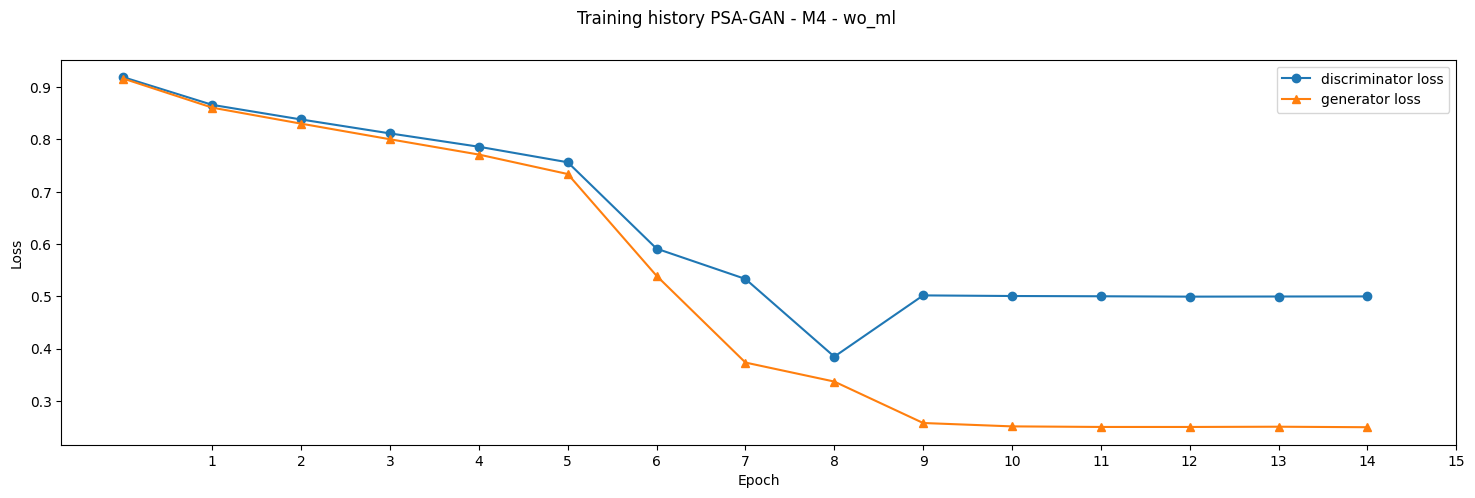

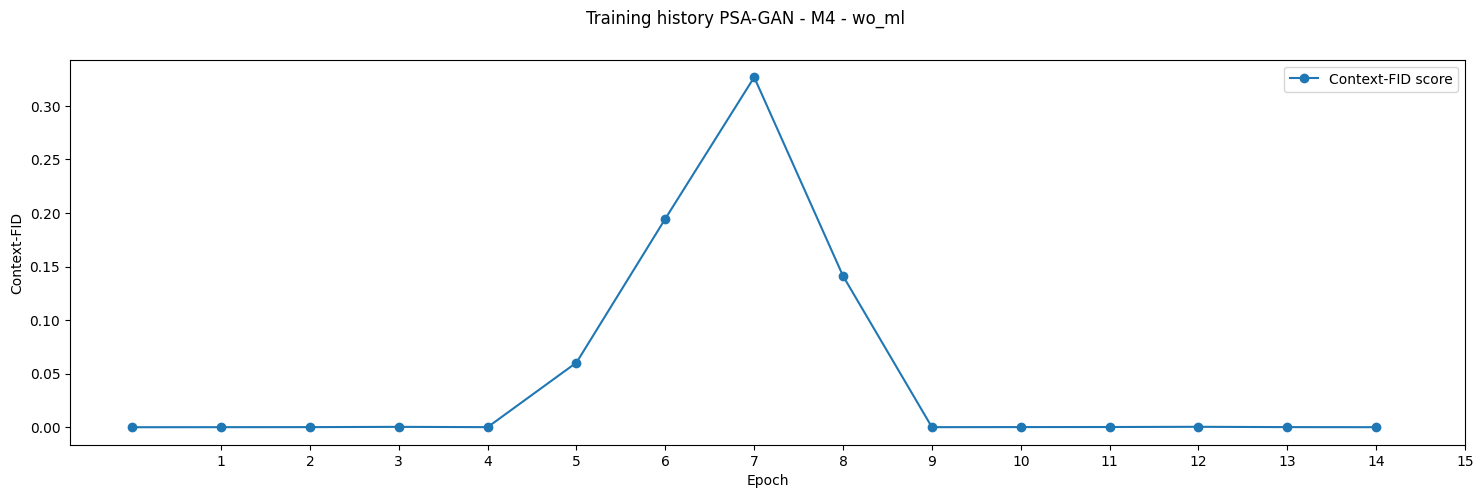

In [14]:
%%time

name_model="wo_ml"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=121,
    discriminator_lr=0.00005,
    generator_lr=0.00005,
    num_epochs=15,
    blocks_to_add=2,
    timestamp=5,
    ml=False,
    fade_in=True,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 347/347 [00:03<00:00, 98.18it/s] 


wo_ml  NRMSE: 0.004710676614195108


100%|██████████| 347/347 [00:56<00:00,  6.18it/s]


FID = 1.597346144519405e-07 +- 1.597346144519405e-07
NRMSE on test set:  tensor(0.3187)


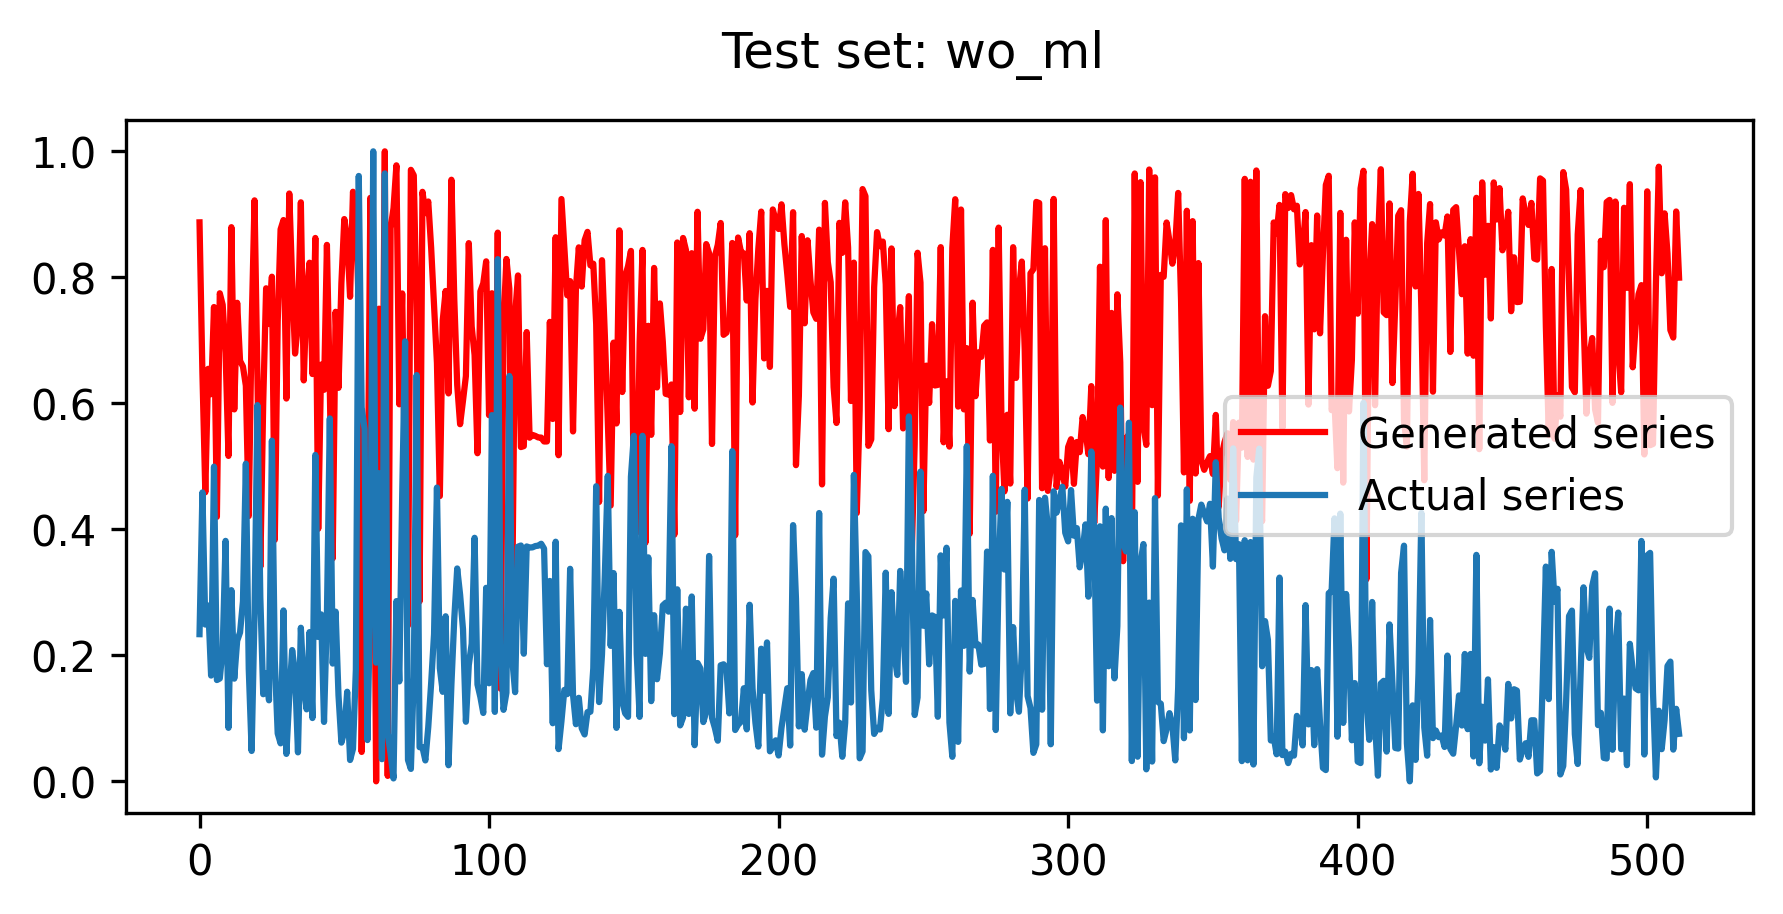

In [15]:
#name_model='wo_ml'
#G,D = utils.load_model(path, name_model)

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper)

plotting.prediction_test(seq_length, 121, test_set, testX, G, name_model)



In [16]:
utils.free_gpu(G)

## w/o  ML and Fade-in

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_ml_fade/

Starting training: wo_ml_fade
Total Epochs: 15 
Blocks to add with fade: 2
Timestamp to add blocks: 5
Fade-in False
ML False
SA True

[Epoch 1/15] [Batch 1/347] [D loss: 1.716567] [G loss: 1.638460] [Fade-in: 1.000000] [FID: 0.000045]
[Epoch 1/15] [Batch 2/347] [D loss: 1.716915] [G loss: 1.638380] [Fade-in: 1.000000] [FID: 0.000027]
[Epoch 1/15] [Batch 3/347] [D loss: 1.716789] [G loss: 1.638245] [Fade-in: 1.000000] [FID: 0.000025]
[Epoch 1/15] [Batch 4/347] [D loss: 1.716612] [G loss: 1.638093] [Fade-in: 1.000000] [FID: 0.000024]
[Epoch 1/15] [Batch 5/347] [D loss: 1.716426] [G loss: 1.637941] [Fade-in: 1.000000] [FID: 0.000022]
[Epoch 1/15] [Batch 6/347] [D loss: 1.716241] [G loss: 1.637789] [Fade-in: 1.000000] [FID: 0.000022]
[Epoch 1/15] [Batch 7/347] [D loss: 1.716054] [G loss: 1.637635] [Fade-in: 1.000000] [FID: 0.000021]
[Epoch 1/15] [Batch 8/347] [D loss: 1.715868] [G loss: 1.637483] [Fade-in: 1.000000] [

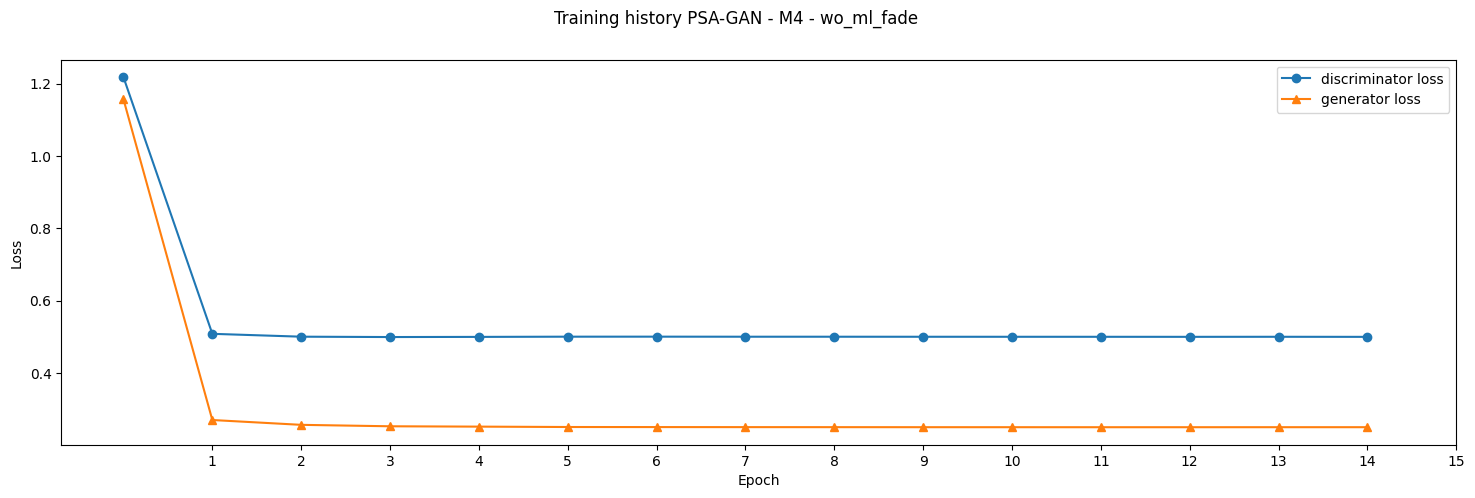

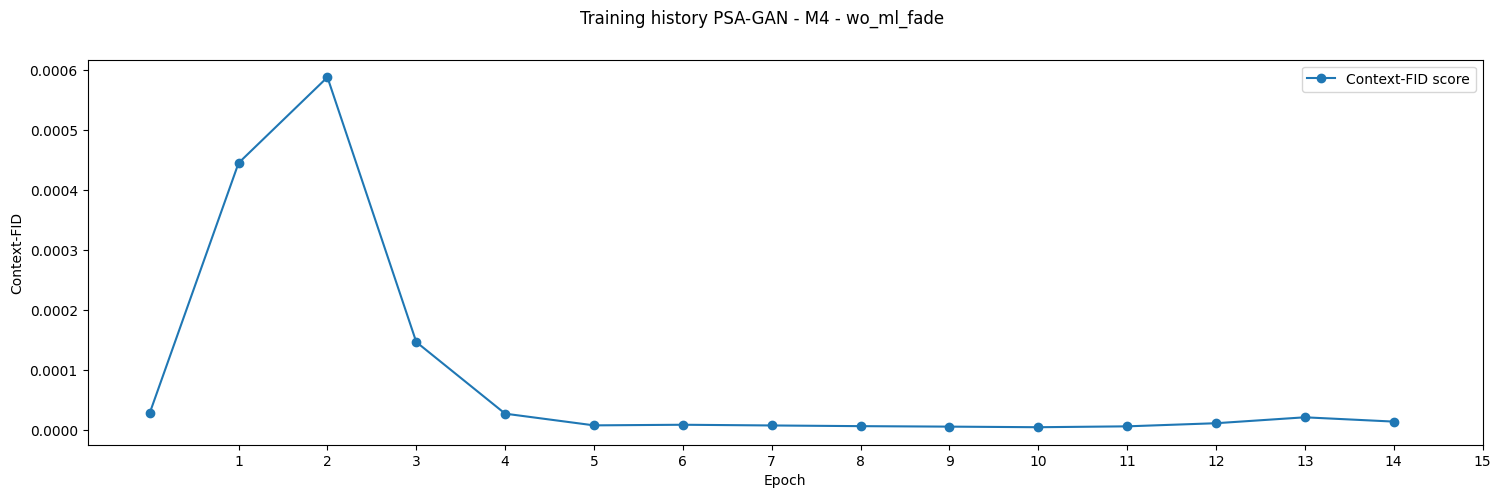

In [41]:
%%time

name_model="wo_ml_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=121,
    discriminator_lr=0.00005,
    generator_lr=0.00005,
    num_epochs=15,
    blocks_to_add=2,
    timestamp=5,
    ml=False,
    fade_in=False,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 347/347 [00:03<00:00, 96.24it/s]


wo_ml_fade  NRMSE: 1.3558927774429321


100%|██████████| 347/347 [00:58<00:00,  5.95it/s]


FID = 0.00383748834430989 +- 0.00383748834430989
NRMSE on test set:  tensor(59.7040)


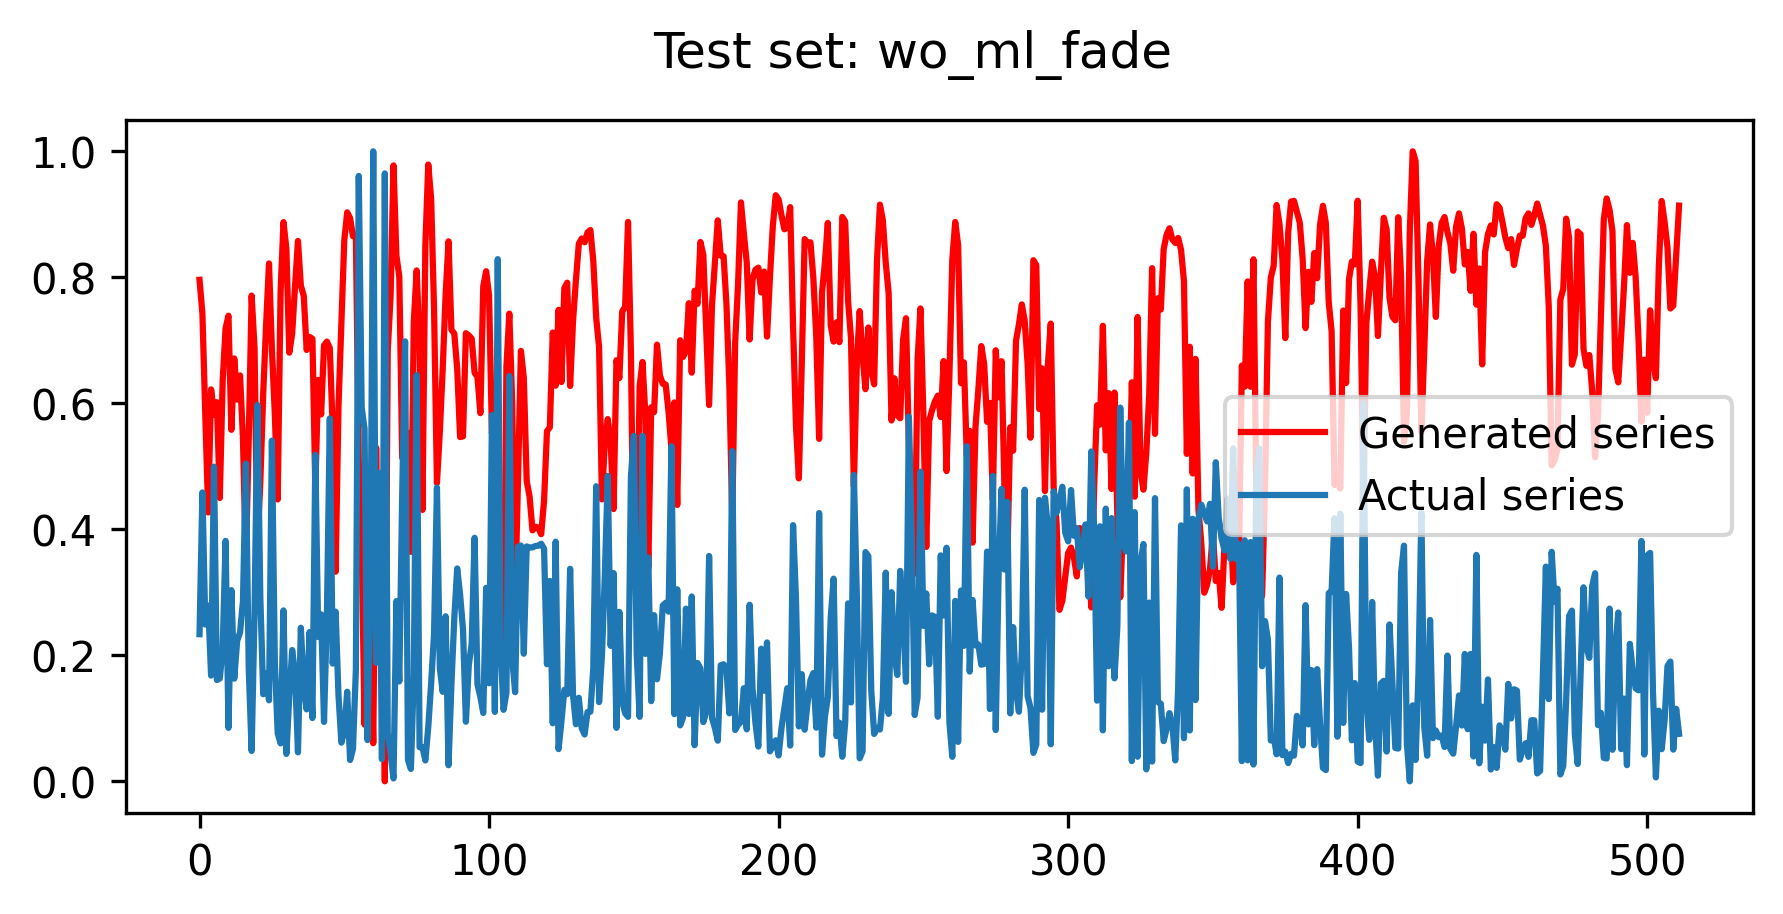

In [42]:
#name_model='wo_ml_fade'
#G,D = utils.load_model(path, name_model)

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper)

plotting.prediction_test(seq_length, 121, test_set, testX, G, name_model)

In [43]:
utils.free_gpu(G)

## w/o SA

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_sa/

Starting training: wo_sa
Total Epochs: 15 
Blocks to add with fade: 2
Timestamp to add blocks: 5
Fade-in True
ML True
SA False

[Epoch 1/15] [Batch 1/347] [D loss: 0.517112] [G loss: 0.631940] [Fade-in: 1.000000] [FID: 0.000041]
[Epoch 1/15] [Batch 2/347] [D loss: 0.508064] [G loss: 0.544840] [Fade-in: 1.000000] [FID: 0.000028]
[Epoch 1/15] [Batch 3/347] [D loss: 0.507213] [G loss: 0.535292] [Fade-in: 1.000000] [FID: 0.000027]
[Epoch 1/15] [Batch 4/347] [D loss: 0.507009] [G loss: 0.531429] [Fade-in: 1.000000] [FID: 0.000025]
[Epoch 1/15] [Batch 5/347] [D loss: 0.506872] [G loss: 0.517264] [Fade-in: 1.000000] [FID: 0.000024]
[Epoch 1/15] [Batch 6/347] [D loss: 0.506743] [G loss: 0.515909] [Fade-in: 1.000000] [FID: 0.000023]
[Epoch 1/15] [Batch 7/347] [D loss: 0.506616] [G loss: 0.511006] [Fade-in: 1.000000] [FID: 0.000023]
[Epoch 1/15] [Batch 8/347] [D loss: 0.506490] [G loss: 0.497708] [Fade-in: 1.000000] [FID: 0.0000

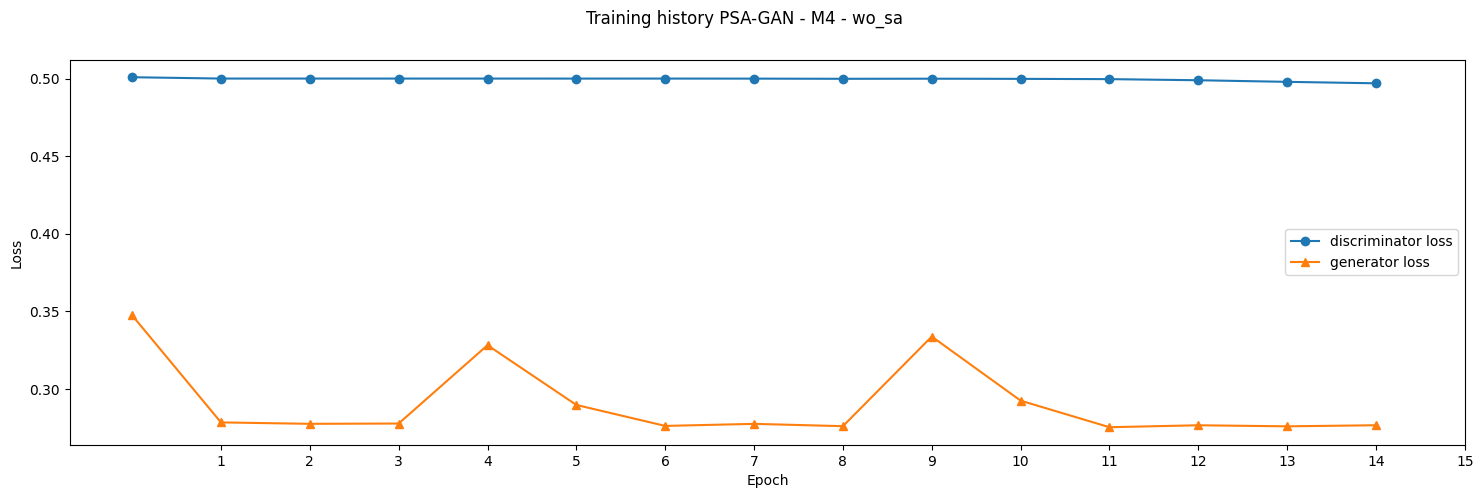

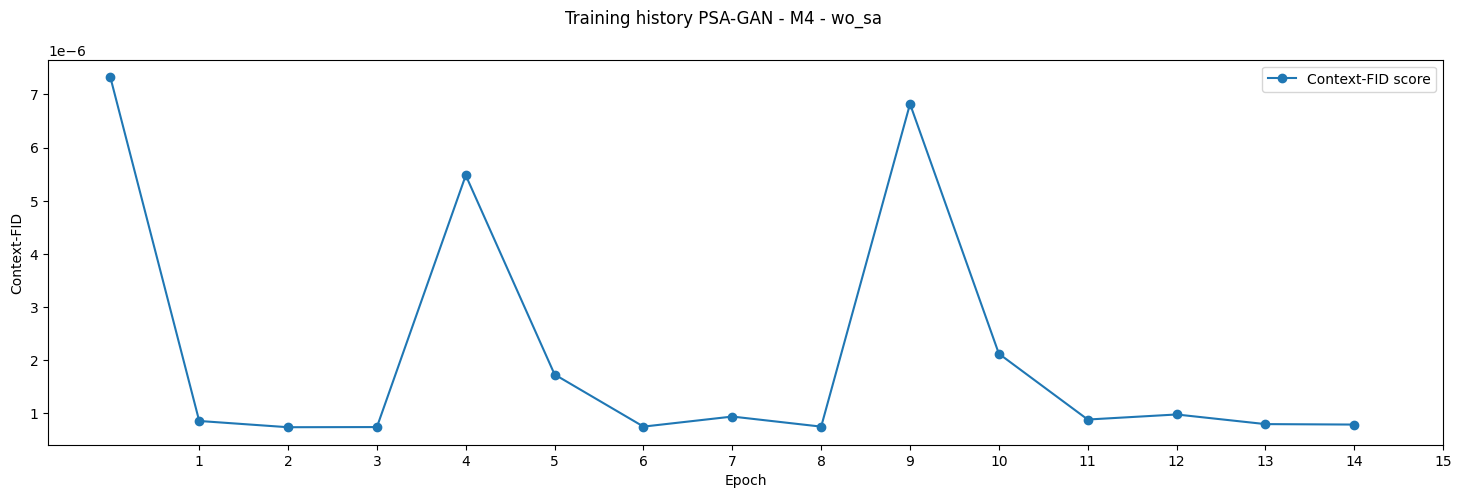

In [20]:
%%time

name_model="wo_sa"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=121,
    discriminator_lr=0.00005,
    generator_lr=0.00005,
    num_epochs=15,
    blocks_to_add=2,
    timestamp=5,
    ml=True,
    fade_in=True,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)


100%|██████████| 347/347 [00:02<00:00, 146.29it/s]


wo_sa  NRMSE: 0.001931312377564609


100%|██████████| 347/347 [00:54<00:00,  6.35it/s]


FID = 1.2687641280211481e-08 +- 1.2687641280211481e-08
NRMSE on test set:  tensor(0.2372)


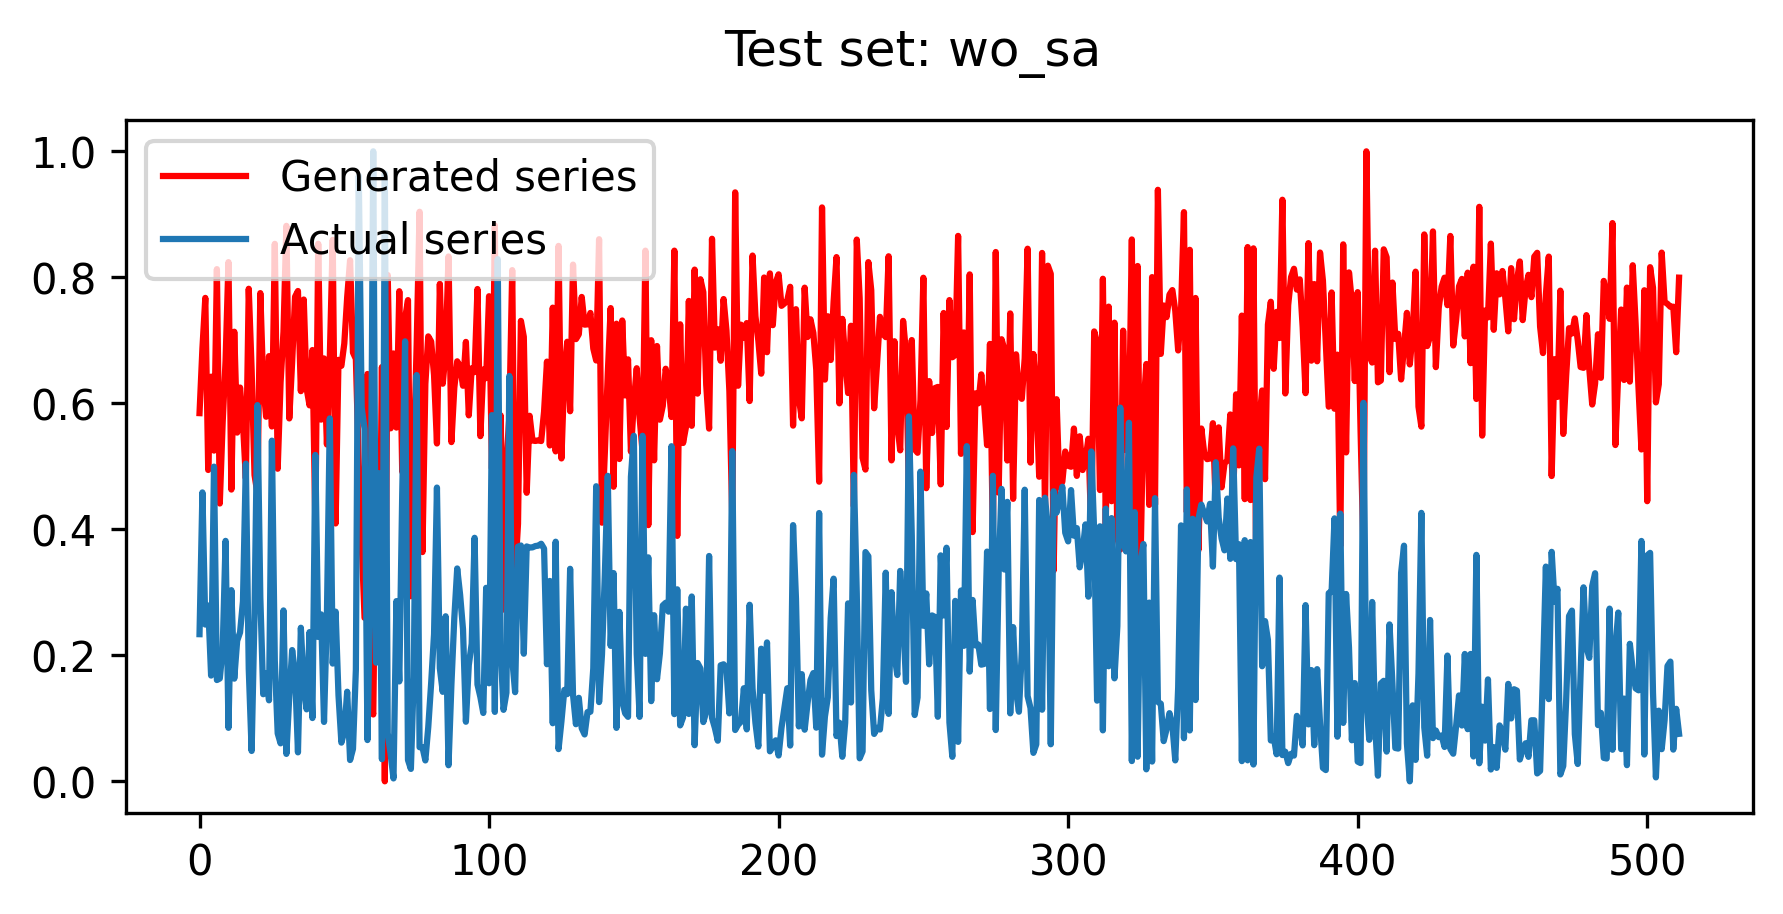

In [21]:
#name_model='wo_sa'
#G,D = utils.load_model(path, name_model)

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper)

plotting.prediction_test(seq_length, 121, test_set, testX, G, name_model)

In [22]:
utils.free_gpu(G)

## w/o SA and fade

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_sa_fade/

Starting training: wo_sa_fade
Total Epochs: 15 
Blocks to add with fade: 2
Timestamp to add blocks: 5
Fade-in False
ML True
SA False

[Epoch 1/15] [Batch 1/347] [D loss: 1.001017] [G loss: 1.526669] [Fade-in: 1.000000] [FID: 0.000095]
[Epoch 1/15] [Batch 2/347] [D loss: 1.000947] [G loss: 1.440380] [Fade-in: 1.000000] [FID: 0.000072]
[Epoch 1/15] [Batch 3/347] [D loss: 1.000836] [G loss: 1.437226] [Fade-in: 1.000000] [FID: 0.000069]
[Epoch 1/15] [Batch 4/347] [D loss: 1.000724] [G loss: 1.438291] [Fade-in: 1.000000] [FID: 0.000068]
[Epoch 1/15] [Batch 5/347] [D loss: 1.000613] [G loss: 1.426492] [Fade-in: 1.000000] [FID: 0.000065]
[Epoch 1/15] [Batch 6/347] [D loss: 1.000501] [G loss: 1.426566] [Fade-in: 1.000000] [FID: 0.000065]
[Epoch 1/15] [Batch 7/347] [D loss: 1.000390] [G loss: 1.422347] [Fade-in: 1.000000] [FID: 0.000063]
[Epoch 1/15] [Batch 8/347] [D loss: 1.000279] [G loss: 1.409585] [Fade-in: 1.000000] [

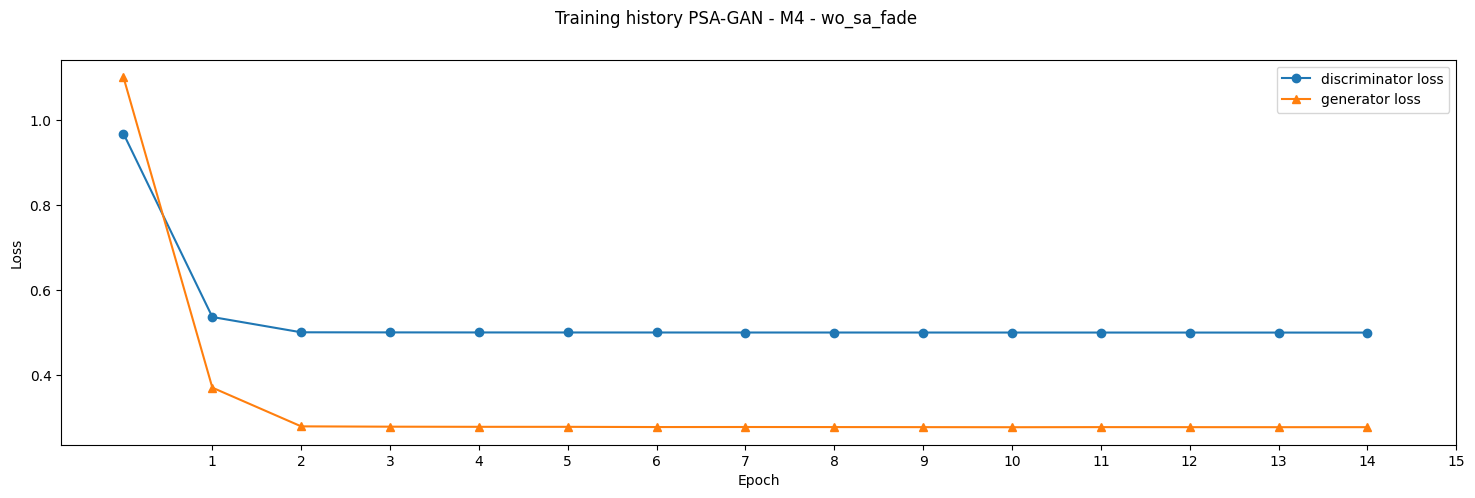

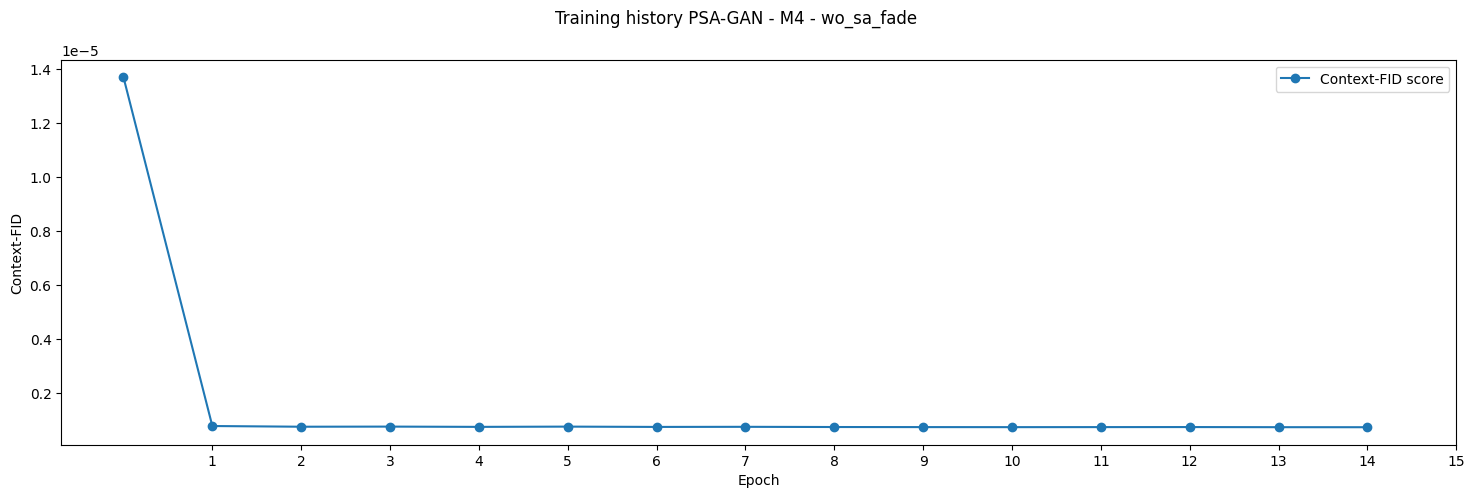

In [47]:
%%time

name_model="wo_sa_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=121,
    discriminator_lr=0.00005,
    generator_lr=0.00005,
    num_epochs=15,
    blocks_to_add=2,
    timestamp=5,
    ml=True,
    fade_in=False,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)


100%|██████████| 347/347 [00:02<00:00, 124.26it/s]


wo_sa_fade  NRMSE: 50.15591812133789


100%|██████████| 347/347 [01:02<00:00,  5.51it/s]

FID = 0.014114300537595497 +- 0.014114300537595497
NRMSE on test set:  tensor(2197.3779)


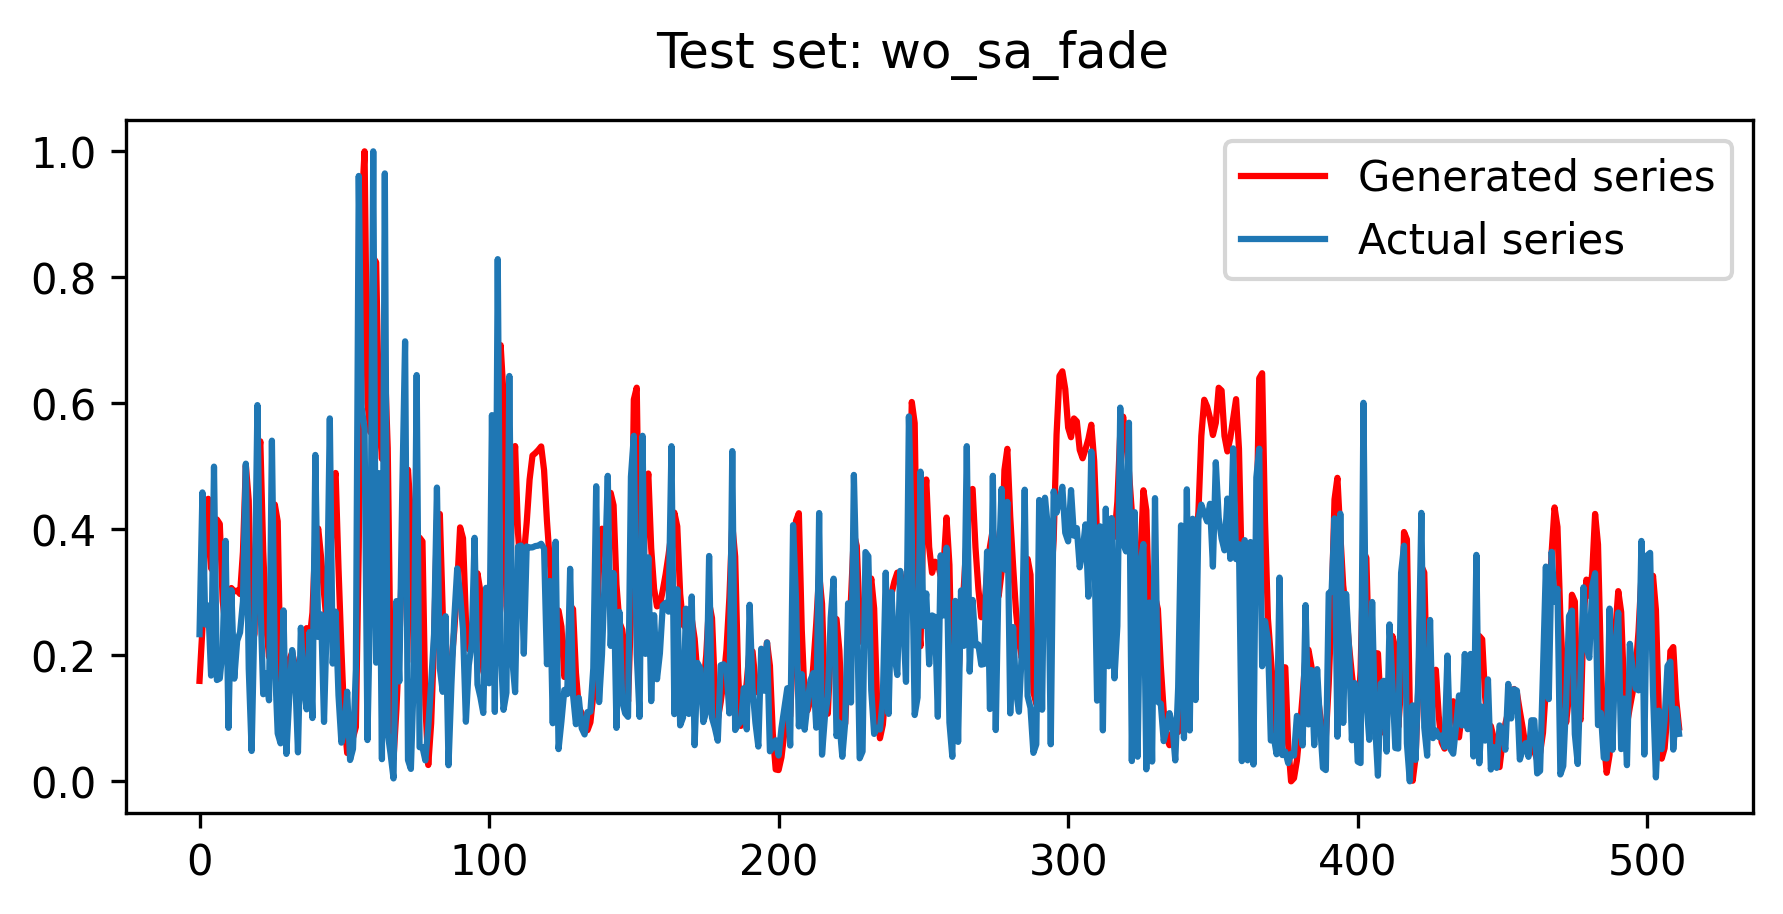

In [48]:
#name_model='wo_sa_fade'
#G,D = utils.load_model(path, name_model)

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper)

plotting.prediction_test(seq_length, 121, test_set, testX, G, name_model)

In [49]:
utils.free_gpu(G)

## w/o SA and ML

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_sa_ml/

Starting training: wo_sa_ml
Total Epochs: 15 
Blocks to add with fade: 2
Timestamp to add blocks: 5
Fade-in True
ML False
SA False

[Epoch 1/15] [Batch 1/347] [D loss: 0.575907] [G loss: 0.487147] [Fade-in: 1.000000] [FID: 0.000103]
[Epoch 1/15] [Batch 2/347] [D loss: 0.578508] [G loss: 0.486919] [Fade-in: 1.000000] [FID: 0.000084]
[Epoch 1/15] [Batch 3/347] [D loss: 0.578295] [G loss: 0.486178] [Fade-in: 1.000000] [FID: 0.000079]
[Epoch 1/15] [Batch 4/347] [D loss: 0.577887] [G loss: 0.485409] [Fade-in: 1.000000] [FID: 0.000076]
[Epoch 1/15] [Batch 5/347] [D loss: 0.577428] [G loss: 0.484584] [Fade-in: 1.000000] [FID: 0.000075]
[Epoch 1/15] [Batch 6/347] [D loss: 0.576973] [G loss: 0.483784] [Fade-in: 1.000000] [FID: 0.000075]
[Epoch 1/15] [Batch 7/347] [D loss: 0.576520] [G loss: 0.482968] [Fade-in: 1.000000] [FID: 0.000076]
[Epoch 1/15] [Batch 8/347] [D loss: 0.576057] [G loss: 0.482147] [Fade-in: 1.000000] [FID:

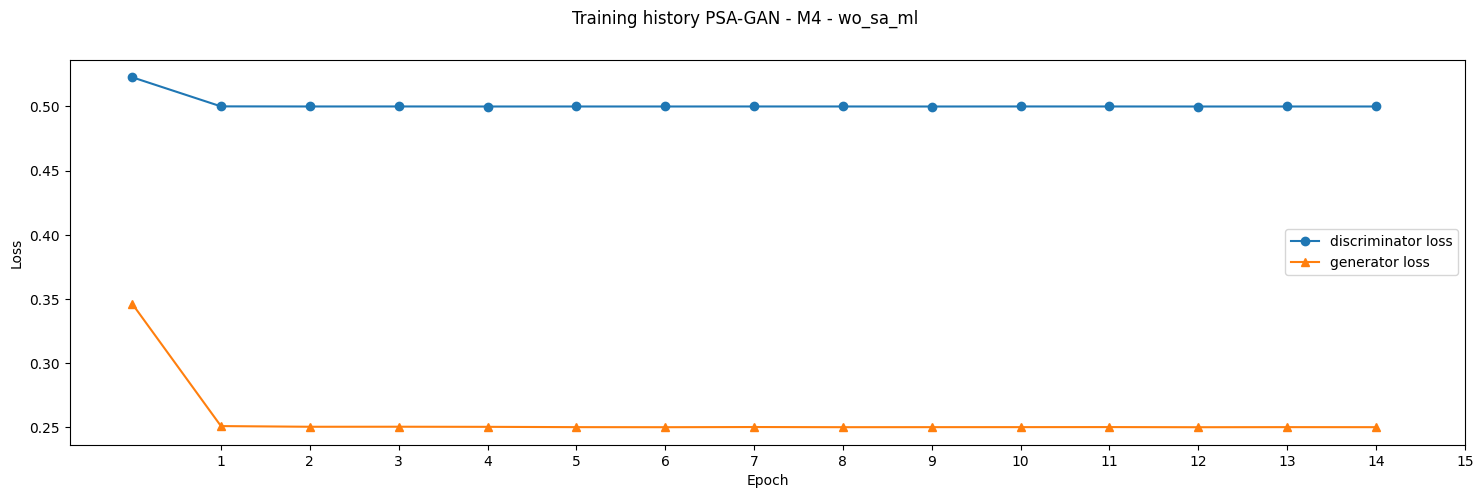

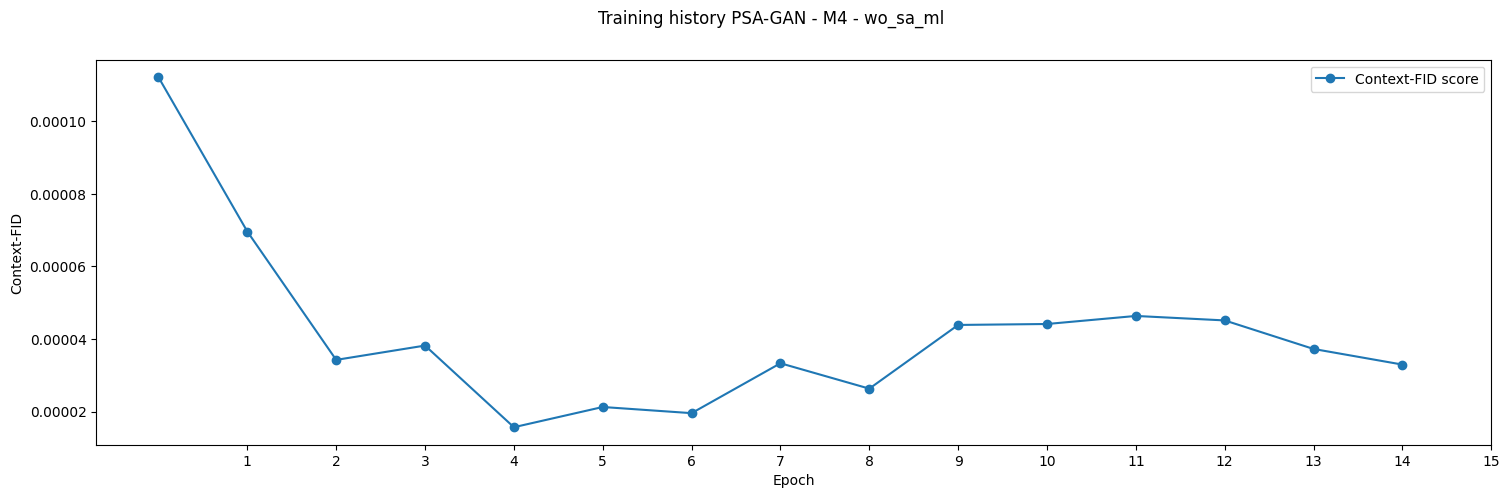

In [44]:
%%time

name_model="wo_sa_ml"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=121,
    discriminator_lr=0.00005,
    generator_lr=0.00005,
    num_epochs=15,
    blocks_to_add=2,
    timestamp=5,
    ml=False,
    fade_in=True,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 347/347 [00:02<00:00, 122.86it/s]


wo_sa_ml  NRMSE: 0.008466175757348537


100%|██████████| 347/347 [01:01<00:00,  5.69it/s]

FID = 6.600678240814785e-07 +- 6.600678240814785e-07
NRMSE on test set:  tensor(0.3068)


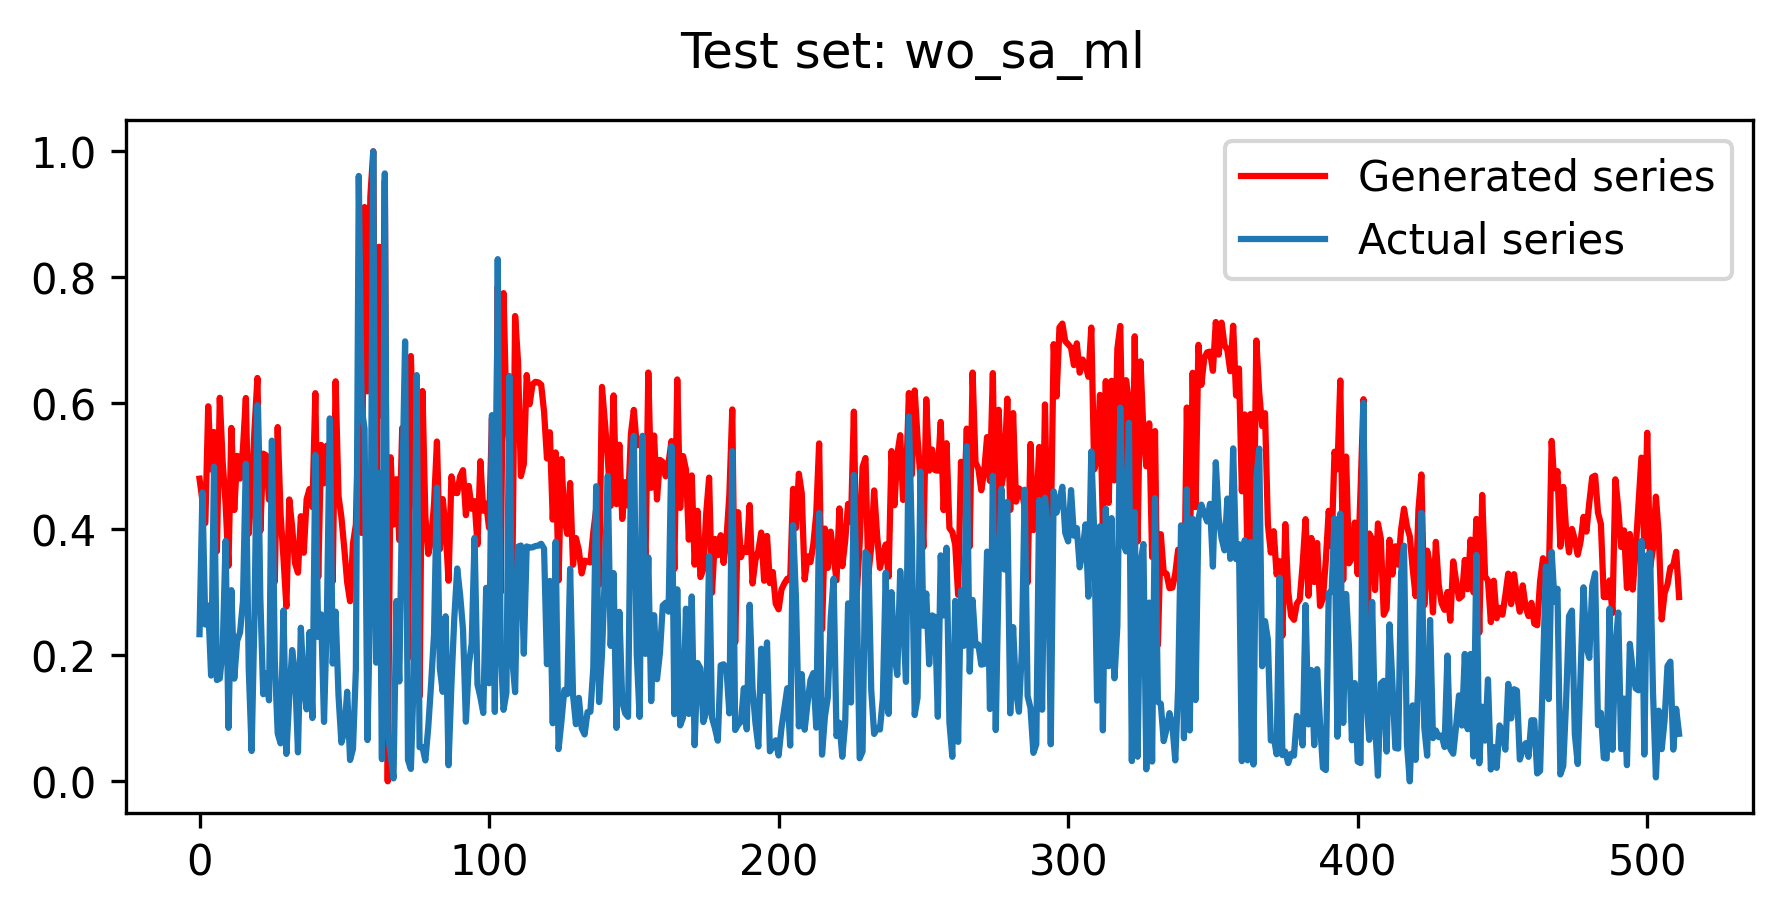

In [45]:
#name_model='wo_sa_ml'
#G,D = utils.load_model(path, name_model)

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper)

plotting.prediction_test(seq_length, 121, test_set, testX, G, name_model)

In [46]:
utils.free_gpu(G)

## w/o SA and ML and Fade

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_sa_ml_fade/

Starting training: wo_sa_ml_fade
Total Epochs: 15 
Blocks to add with fade: 2
Timestamp to add blocks: 5
Fade-in False
ML False
SA False

[Epoch 1/15] [Batch 1/347] [D loss: 1.219290] [G loss: 1.209448] [Fade-in: 1.000000] [FID: 0.000045]
[Epoch 1/15] [Batch 2/347] [D loss: 1.219398] [G loss: 1.209325] [Fade-in: 1.000000] [FID: 0.000035]
[Epoch 1/15] [Batch 3/347] [D loss: 1.219265] [G loss: 1.209202] [Fade-in: 1.000000] [FID: 0.000033]
[Epoch 1/15] [Batch 4/347] [D loss: 1.219131] [G loss: 1.209077] [Fade-in: 1.000000] [FID: 0.000031]
[Epoch 1/15] [Batch 5/347] [D loss: 1.218994] [G loss: 1.208952] [Fade-in: 1.000000] [FID: 0.000030]
[Epoch 1/15] [Batch 6/347] [D loss: 1.218857] [G loss: 1.208826] [Fade-in: 1.000000] [FID: 0.000030]
[Epoch 1/15] [Batch 7/347] [D loss: 1.218720] [G loss: 1.208701] [Fade-in: 1.000000] [FID: 0.000029]
[Epoch 1/15] [Batch 8/347] [D loss: 1.218584] [G loss: 1.208576] [Fade-in: 1.00

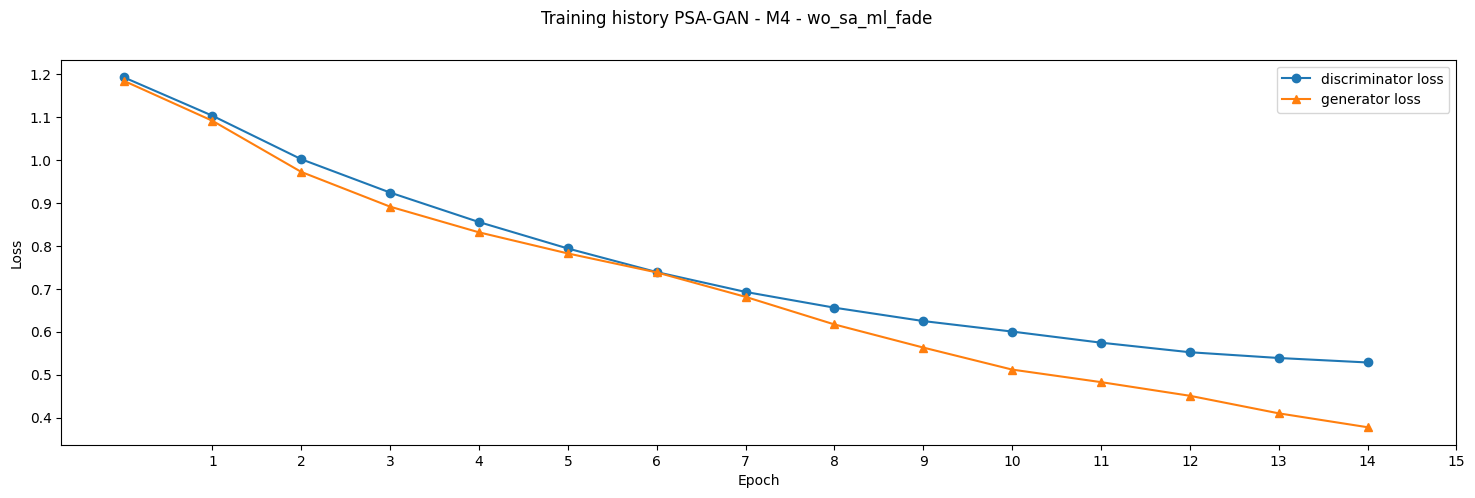

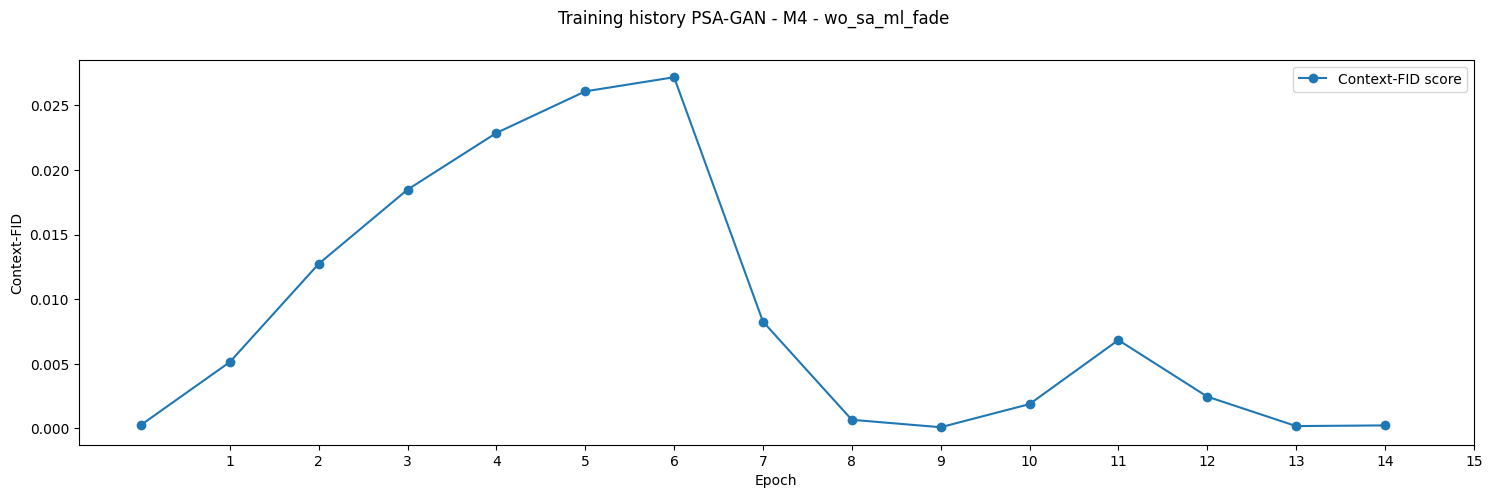

In [32]:
%%time

name_model="wo_sa_ml_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=121,
    discriminator_lr=0.00005,
    generator_lr=0.00005,
    num_epochs=15,
    blocks_to_add=2,
    timestamp=5,
    ml=False,
    fade_in=False,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 347/347 [00:02<00:00, 144.82it/s]


wo_sa_ml_fade  NRMSE: 0.267531156539917


100%|██████████| 347/347 [00:56<00:00,  6.17it/s]


FID = 0.0006530974502060591 +- 0.0006530974502060591
NRMSE on test set:  tensor(11.7129)


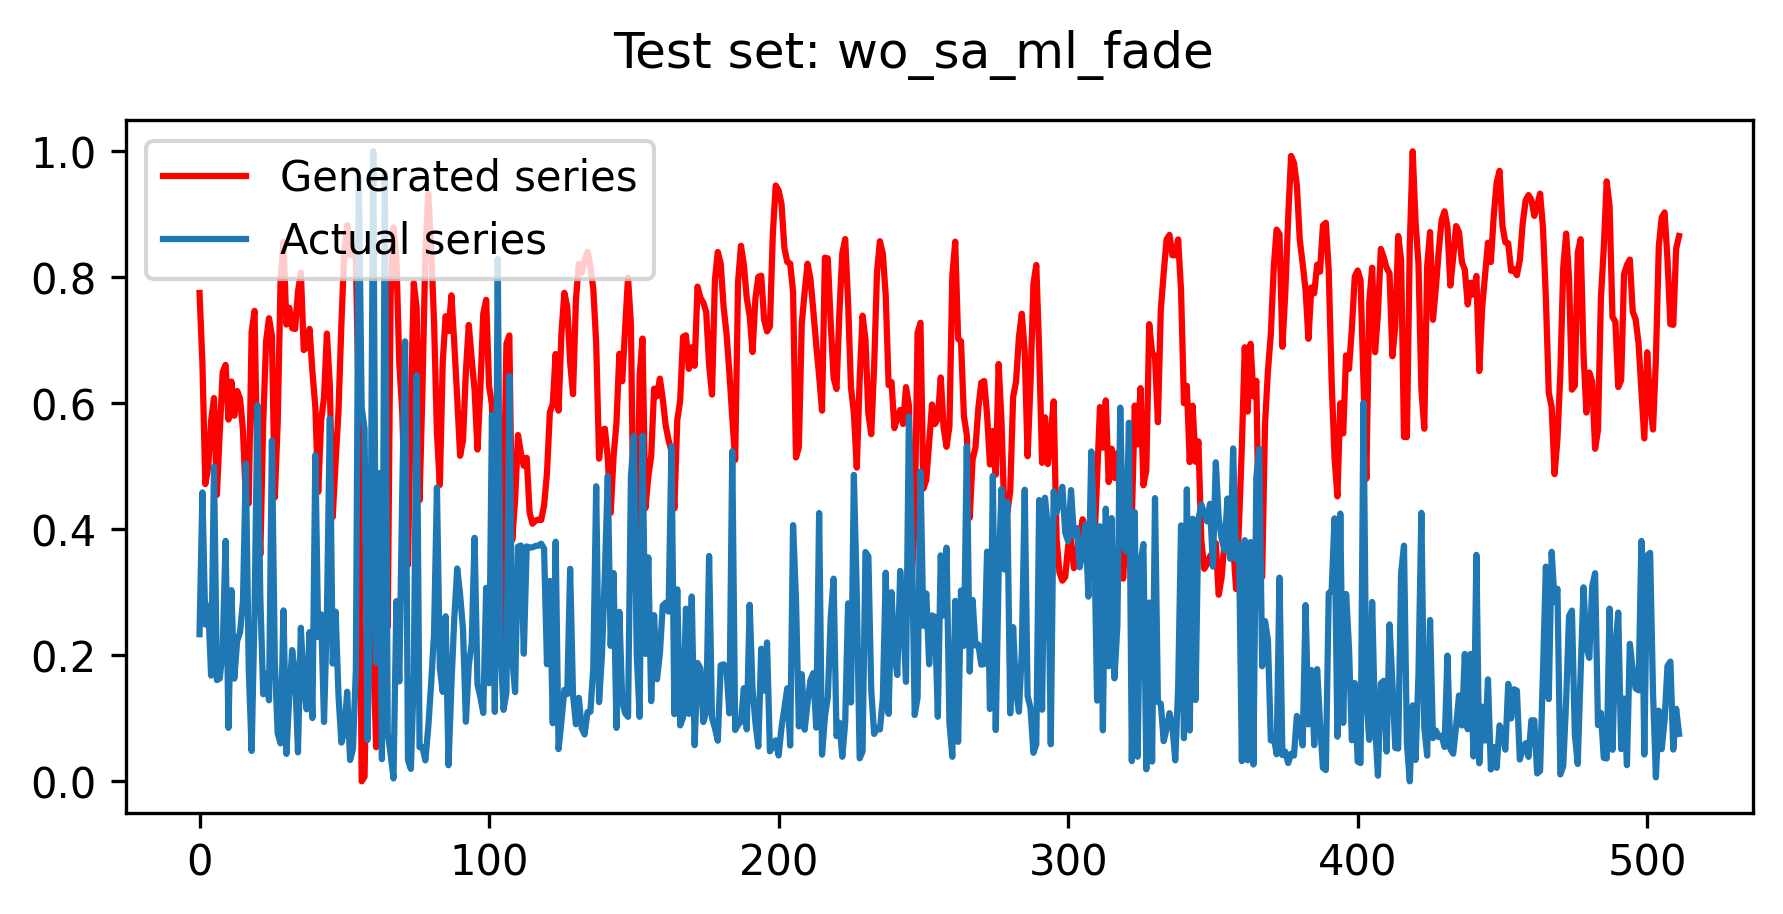

In [33]:
#name_model='wo_sa_ml_fade'
#G,D = utils.load_model(path, name_model)

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper)

plotting.prediction_test(seq_length, 121, test_set, testX, G, name_model)

In [34]:
utils.free_gpu(G)